<h1 style="text-align:center">Twitter Downloader</h1>

<span style="font-family:monospace">
Autor: Cicero Tiago<br>
Criado em: 13 de junho de 2020<br>
Sem nenhum motivo relevante;
</span>

<h2>Importando as bibliotecas necessárias</h2>

É importante lembrar que **todo** o código aqui escrito foi pensando para rodar em `jupyter`. Se você quiser criar um script, é preciso que faça algumas modificações.

In [163]:
try:
    import tweepy
except:
    !pip install tweepy
finally:
    import tweepy
try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
finally:
    from wordcloud import WordCloud

import pandas as pd
import numpy as np
import time
import json
import re
from os import listdir
from stopwords import stopWords

<h2>Carregando as credenciais</h2>
<p>Legalmente, o twitter exige que você tenha autorização para baixar dados de lá.<br>Para conseguir autorização, <a href="https://developer.twitter.com/en/docs/basics/getting-started"><strong>clique aqui</strong></a> e procure pela seção <strong>How to get started with the Twitter APIs</strong>.</p>

Suas credenciais devem ser algo parecido com isso:


``` python
{
 'consumer_key': 'A7JZWbYwBybWeiAYB84S6gvwy',
 'consumer_secret': 'iSAIgxVObcBTIzI2pLdeEtnNxU5tXqEOK1PRqM2fblNb3DHsYe',
 'access_token': '7vJP5O5Lyd9764-y1uuSe78e844pQ50AMn16g2816Y67I8j01P',
 'access_token_secret': 'Hv0VIZ5Bq53lPR1jsESD4mVUQpPm94zmngvrN4mW04pwId'
}
```

(<i>keys meramente ilustrativas</i>)
<p>No meu caso, salvei em um arquivo chamado <b style="color:red">auth.json</b></p>

In [7]:
# open credentials
with open("auth.json", "r") as auth:
    credentials = json.load(auth)

In [8]:
consumerKey = credentials["consumer_key"]
consumerSecret = credentials["consumer_secret"]
accessToken = credentials["access_token"]
accessTokenSecret = credentials["access_token_secret"]

In [9]:
# criar o "objeto" de autenticação
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# setar access token e access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

# Criar o objeto API
api = tweepy.API(authenticate, wait_on_rate_limit=True)

<h2>Função que carrega <i>tweets</i> já baixados de um arquivo</h2>
<p style="max-width:70vw">Essa função serve para fazer <i>checkpoints</i>.</p>

In [39]:
def load_tweets(id) -> list:
    id = id.replace("@","")
    if ".database" in listdir():
        if id in listdir(".database"):
            with open(".database/"+id, 'r') as file:
                tweets = [json.loads(line) for line in file.readlines()]
            print(f"{len(tweets)} Tweets carregados de .database/{id}")
        else:
            print(f"Nenhum tweet em .database/{id}")
            tweets = []
    else:
        !md ".database"
        tweets = [] 
    return tweets

<h2>Função que salva <i>tweets</i> baixados em um arquivo</h2>
<p style="max-width:70vw">Essa função serve para fazer <i>checkpoints</i>.</p>

In [11]:
def save_tweets(id, tweets_list):
    with open(f".database/{id}", 'w+') as file:
        file.write("\n".join([json.dumps(list_item) for list_item in tweets_list]))

<h2>Função que carrega e baixa <i>tweets</i></h2>
<p style="max-width:70vw">Essa função baixa <i>tweets</i> e retorna uma lista de dicionários.</p>

**`id:str`**: id do usuário com ou sem "@"<br>
**`count:int`**: quantidade de tweets a serem baixados; `default=9999`<br>
**`download:bool`**: baixa novos tweets se for `True`; `default=False`<br>

In [178]:
def get_tweets_list(id: str, count: int = 9999, download: bool = False) -> list:
    id = id.replace("@", "")
    global global_status

    # essa função serve para lidar com os finais das iterações
    def limit_handled(cursor):
        running = True
        while running:
            try:
                yield cursor.next()
            except tweepy.RateLimitError:
                print(
                    f"Atingiu o Limite de downloads. Aguarde até: {time.ctime(time.time()+15*60)} para continuar.")
                running = not running
            except StopIteration:
                print("Terminou todas as iterações")
                return None

    # tenta carregar tweets já baixados
    tweets = load_tweets(id=id)

    # se o parâmetro download for falso, retorna a lista de tweets que foi carregada de .database
    if not download:
        if not tweets:
            print("Nenhum tweet foi baixado. Use download=True para baixar")
        return tweets
    # cria uma lista de timestamps (certamente únicos)
    timestamps = [tweet["ID"] for tweet in tweets]

    # controle
    tweets_repetidos = 0
    tweets_baixados = 0

    # loop principal
    for status in limit_handled(tweepy.Cursor(api.user_timeline, id=id, tweet_mode="extended").items(count)):
        # se a timestamp do tweet baixado não existir na lista
        if (status.id) not in timestamps:
            tweets_baixados += 1
            tweet = {}
            tweet["ID"] = status.id
            tweet['User_Name'] = status.user.name
            tweet['Created_At'] = int(status.created_at.timestamp())
            tweet['Text'] = status.full_text
            tweet['Phone_Type'] = status.source
            tweet['Favorite_Count'] = status.favorite_count
            tweet['Retweets'] = status.retweet_count
            if status.entities["user_mentions"]:
                tweet['Mentions'] = [mention["screen_name"] for mention in status.entities["user_mentions"]]
            if status.entities["hashtags"]:
                tweet['Hashtags'] = [hashtag['text'] for hashtag in status.entities["hashtags"]]
            if status.entities["urls"]:
                tweet["Url"] = [url["expanded_url"] for url in status.entities["urls"]] 
            tweet["Language"] = status.lang
            if "media" in status.entities:
                tweet["Media"] = [media["media_url_https"] for media in status.entities["media"]] 
            tweets.append(tweet)
        else:
            tweets_repetidos += 1

    print(f"Tweets repetidos: {max([0,tweets_repetidos])}")
    print(f"Tweets baixados: {tweets_baixados}")
    save_tweets(id=id, tweets_list=tweets)
    return tweets

<h2>Função de limpeza</h2>
<p style="max-width:70vw">Recebe uma string e devolve a mesma string removendo expressões como <strong>mentions</strong>, <strong>links</strongstrong>, <i>retweets</strong> e <strong>hashtags</strong>.</p>

In [179]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9\_]+', '', text)  # remove @mentions
    text = re.sub('#', '', text)  # remove #hashtag
    text = re.sub('RT[\s]+', '', text)  # remove RT
    text = re.sub('https?:\/\/\S+', '', text)  # remove links
    return text

<h2>Frunção que gera o dataframe</h2>
<p style="max-width:70vw">Essa função cria o <i>dataframe</i> e limpa a coluna <strong>Text</strong>.</p>

In [180]:
def create_dataframe(tweet_list) -> pd.DataFrame:
    # função interna que aplica a função de limpeza em um dataframe que possui coluna "Text"
    # não tem problema aplicar ela diretamente no dataframe porque mentions, links e hashtags
    # são guardadas em suas respectivas colunas
    def cleanDataframe(dataframe) -> pd.DataFrame:
        new_df = dataframe.copy()
        new_df['Text'] = new_df['Text'].apply(cleanTxt)
        return new_df

    dataframe = pd.DataFrame(tweet_list)
    return cleanDataframe(dataframe)

<h2>Frunção que gera uma <i>Word Cloud</i></h2>
<p style="max-width:70vw">Essa função gera uma <strong>Word Cloud</strong> partindo de um dataframe limpo.</p>

In [181]:
def generateWordCloud(tweet_dataframe, save: bool = False, width:int=1500, height:int=500):
    tweets = tweet_dataframe["Text"]
    allWords = ' '.join([twts for twts in tweets])
    wc = WordCloud(width=width,
                   height=height,
                   random_state=42,
                   max_font_size=110,
                   stopwords=stopWords)
    gen = wc.generate(allWords)
    return gen.to_image()

<h2>Teste</h2>
<p style="max-width:70vw">Hora de <strong>testar</strong>.</p>

In [186]:
twitter_list = get_tweets_list(id="@cicerotcv", count=200, download=True)

200 Tweets carregados de .database/cicerotcv
Terminou todas as iterações
Tweets repetidos: 199
Tweets baixados: 1


In [183]:
my_tweets = create_dataframe(twitter_list)
print(f"shape: {my_tweets.shape}")

shape: (200, 11)


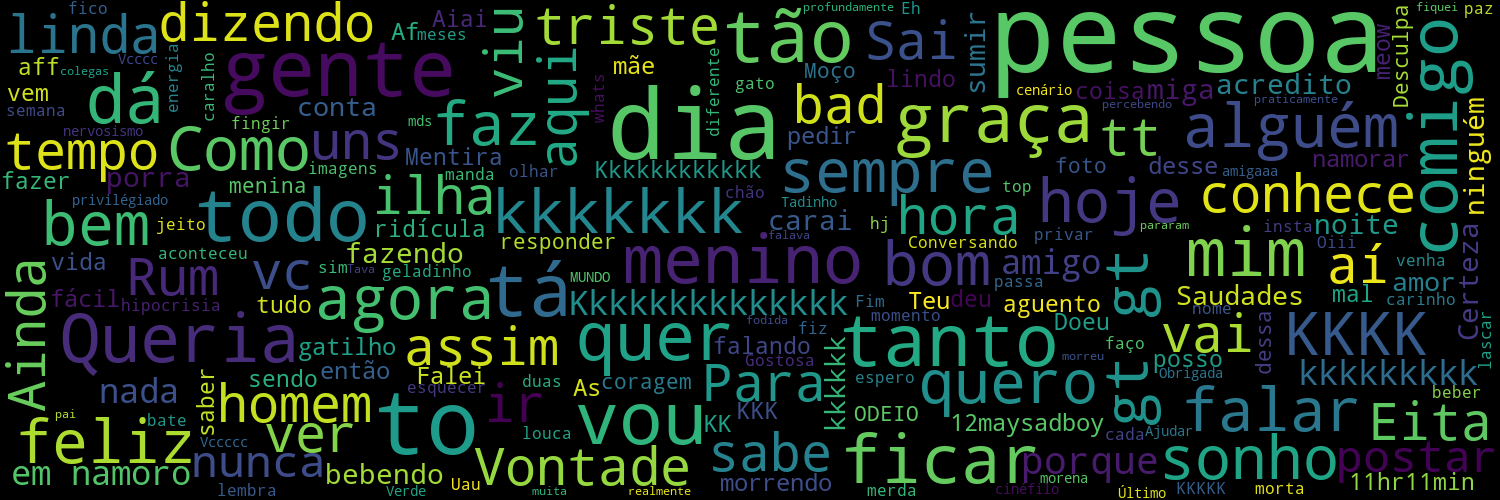

In [184]:
generateWordCloud(my_tweets, width=1500, height=500)

<h2>Extras</h2>
<p style="max-width:70vw; font-family:monospace">Sua análise começa aqui &#128540;</p>

In [147]:
lista_de_lista_de_mentions = my_tweets.Mentions[my_tweets.Mentions.notnull()]
lista_de_mentions = lista_de_lista_de_mentions.sum()

In [ ]:
pd.Series(lista_de_mentions).value_counts()

link interessante sobre WordClouds:<br>
https://amueller.github.io/word_cloud/auto_examples/masked.html